In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy import constants 
%matplotlib inline

In [2]:
# Parametersfor the benchmarking
fps=100
num_particles=100
dt=1.0/fps
spatial_resolution=1.0E-8  # in metres per px
dust_diameter=7.14E-6 # in metres
dust_rho=1510.0
mu = 0
mass = 4.0 / 3.0 * np.pi * ( dust_diameter/ 2.0)**3 * dust_rho #mass of the dust particles
# print(mass)
kb=constants.Boltzmann
TeV=0.1
T= TeV*constants.e/kb #temperature in Kelvin (0.13 eV converted to Kelvin))
print(T)
sigma = np.sqrt(kb*T/mass)
print(sigma)

left=0
right=1751 # right border in px as per the camera of expt
up=400 # up border in px as per the camera of expt
down=0
left_SI=left*spatial_resolution
right_SI=right*spatial_resolution
up_SI=up*spatial_resolution
down_SI=down*spatial_resolution
final_frame=2
n_bins=19

1160.4518121550082
0.00023595006124153709


In [3]:
def get_percent_discrepancies(v_restored,v_actual):
    discrepancy = np.abs(v_actual - v_restored)
    # print(np.mean(discrepancy))
    frac_discrepancy = np.abs(discrepancy / v_actual)
    # print(np.mean(frac_discrepancy))
    percent_discrepancy = frac_discrepancy*100
    # print(np.mean(percent_discrepancy))
    return np.mean(percent_discrepancy)

In [4]:
unif_x = sts.uniform(left_SI, right_SI-left_SI)
sample_x_trial=unif_x.rvs(num_particles)
unif_y = sts.uniform(down_SI, up_SI-down_SI)
sample_y_trial=unif_y.rvs(num_particles)

norm_rv = sts.norm(mu, sigma)
sample_vx_trial = norm_rv.rvs(num_particles) #generate a sample of certain size
sample_vy_trial= norm_rv.rvs(num_particles) 



In [5]:
def make_velocities_trial(fps,num_particles,spatial_resolution, final_frame, x_init, y_init, vx_init, vy_init):
    dt=1.0/fps
    init_frame=1
    dust_diameter=7.14E-6 
    dust_rho=1510.0
    mass = 4.0 / 3.0 * np.pi * (dust_diameter/ 2.0)**3 * dust_rho #mass of the dust particles
    # print(mass)
    kb=constants.Boltzmann
    # print(sigma)
    frame_full_df=pd.DataFrame()
    sample_x=x_init
    sample_y=y_init
    sample_vx=vx_init
    sample_vy=vy_init
    while init_frame<=final_frame:
        if init_frame==1:
            sample_x_in_resol= sample_x/spatial_resolution
            sample_x_trunc= sample_x_in_resol.astype('int64')
            sample_x_trunc_SI=sample_x_trunc.astype('float64')*spatial_resolution

            sample_y_in_resol= sample_y/spatial_resolution
            sample_y_trunc= sample_y_in_resol.astype('int64')
            sample_y_trunc_SI=sample_y_trunc.astype('float64')*spatial_resolution

            part_no = np.arange(0,num_particles,dtype = 'int') # array of particles ID numbers
                
        # Simulating the motion of the particles for x coordinates
        x_forward = sample_x_trunc_SI + sample_vx*dt
        x_forward_in_resol = x_forward / spatial_resolution
        x_forward_trunc = x_forward_in_resol.astype('int64')
        x_forward_SI = x_forward_trunc.astype('float64') * spatial_resolution
        # Simulating the motion of the particles for y coordinates
        y_forward = sample_y_trunc_SI + sample_vy * dt
        y_forward_in_resol = y_forward / spatial_resolution
        y_forward_trunc = y_forward_in_resol.astype('int64')
        y_forward_SI=y_forward_trunc.astype('float64')*spatial_resolution

        # Calculating restored velocities
        v_restored_x=(x_forward_SI- sample_x_trunc_SI)/dt
        v_restored_y=(y_forward_SI- sample_y_trunc_SI)/dt
        # Append the data for the current frame
        frame_data={'part_no':part_no, 'x': sample_x_trunc_SI, 'y':sample_y_trunc_SI, 'frame': init_frame,'vx (restored)': v_restored_x, 'vy (restored)': v_restored_y, 'vx': sample_vx, 'vy': sample_vy}
        frame_df=pd.DataFrame(frame_data)
        frame_full_df = pd.concat([frame_full_df, frame_df], ignore_index=True)
        sample_x_trunc_SI=x_forward_SI
        sample_y_trunc_SI= y_forward_SI
        init_frame+=1
    return frame_full_df

In [6]:
trial=make_velocities_trial(fps,num_particles,spatial_resolution, 2, sample_x_trial, sample_y_trial, sample_vx_trial, sample_vy_trial)
trial

,part_no,x,y,frame,vx (restored),vy (restored),vx,vy
0,0,1.095000e-05,8.700000e-07,1,0.000210,0.000059,0.000210,0.000060
1,1,1.407000e-05,1.150000e-06,1,0.000374,0.000001,0.000375,0.000002
2,2,4.580000e-06,1.840000e-06,1,-0.000592,0.000183,-0.000593,0.000183
3,3,7.910000e-06,1.330000e-06,1,0.000196,-0.000346,0.000196,-0.000346
4,4,6.000000e-07,3.630000e-06,1,0.000049,0.000373,0.000050,0.000373
...,...,...,...,...,...,...,...,...
195,95,4.630000e-06,2.880000e-06,2,0.000306,0.000080,0.000307,0.000080
196,96,1.228000e-05,2.200000e-07,2,-0.000267,-0.000354,-0.000266,-0.000355
197,97,1.508000e-05,2.410000e-06,2,0.000183,0.000078,0.000184,0.000078
198,98,1.069000e-05,1.910000e-06,2,0.000455,0.000175,0.000455,0.000175


In [7]:
fps_arr=np.arange(1E1,1E4,1E2)
print(fps_arr)
print(len(fps_arr))


[  10.  110.  210.  310.  410.  510.  610.  710.  810.  910. 1010. 1110.
 1210. 1310. 1410. 1510. 1610. 1710. 1810. 1910. 2010. 2110. 2210. 2310.
 2410. 2510. 2610. 2710. 2810. 2910. 3010. 3110. 3210. 3310. 3410. 3510.
 3610. 3710. 3810. 3910. 4010. 4110. 4210. 4310. 4410. 4510. 4610. 4710.
 4810. 4910. 5010. 5110. 5210. 5310. 5410. 5510. 5610. 5710. 5810. 5910.
 6010. 6110. 6210. 6310. 6410. 6510. 6610. 6710. 6810. 6910. 7010. 7110.
 7210. 7310. 7410. 7510. 7610. 7710. 7810. 7910. 8010. 8110. 8210. 8310.
 8410. 8510. 8610. 8710. 8810. 8910. 9010. 9110. 9210. 9310. 9410. 9510.
 9610. 9710. 9810. 9910.]
100


In [8]:
discrepancy_arr=[]
T_discrepancy_arr=[]
for i in range(len(fps_arr)):
    fps_loop=fps_arr[i]
    df=make_velocities_trial(fps_loop,num_particles,spatial_resolution,2, sample_x_trial, sample_y_trial, sample_vx_trial, sample_vy_trial)
    discrepancy=get_percent_discrepancies(df[df['frame']==1]['vx (restored)'],df[df['frame']==1]['vx'])
    discrepancy_arr.append(discrepancy)
    T_restored=mass*np.std(df[df['frame']==1]['vx (restored)'])**2/constants.Boltzmann
    T_discrepancy_arr.append(np.abs(T-T_restored)/T)

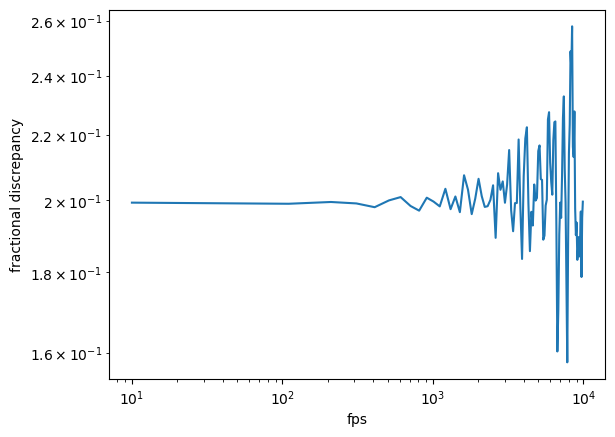

In [9]:
fig, ax = plt.subplots()
ax.plot(fps_arr, T_discrepancy_arr)
ax.set_xlabel('fps')
ax.set_ylabel('fractional discrepancy')
ax.set_xscale('log')
ax.set_yscale('log')